# Modelling a Lens image using MCMC

In this hypothetical scenario we have an image of galaxy galaxy strong lensing and we would like to recover a model of this scene. Thus we will need to determine parameters for the background source light, the lensing galaxy light, and the lensing galaxy mass distribution. A common technique for analyzing strong lensing systems is a Markov Chain Monte-Carlo which can explore the parameter space and provide us with important metrics about the model and uncertainty on all parameters. Since `caustics` is differentiable we have access to especially efficient gradient based MCMC algorithms. First, we will demo a classical MCMC algorithm (using emcee) on the problem and show how for this high dimensional problem the autocorrelation length is high. Next we will show how just adding a bit of gradient information (via MALA) will significantly improve results by reducing autocorrelation length. Finally, we will demo NUTS on the problem, which is highly gradient based and is convenient in that it can be run with no tunable parameters, it's autocorrelation length is generally approximately 1. However, to achieve this, NUTS needs to run many steps internally, which ultimately means that even though it requires more tweaking to set up, MALA, is often more efficient. The best algorithm for your use case will depend on a number of factors, here you will see how `caustics` can play well with any sampling algorithm available, giving you lots of flexibility!

In [1]:
import caustics
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.patches import Ellipse
from scipy.stats import norm
from tqdm.notebook import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC as pyro_MCMC
from pyro.infer import NUTS as pyro_NUTS
import emcee

## Specs for the data

These are some properties of the data that aren't very interesting for the demo, it includes the size of the image, pixelscale, noise level, etc.

In [146]:
# Data specs
seed = 42
torch.manual_seed(seed)

background_rms = 0.005  #  background noise per pixel
exp_time = 500.0  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size per axis
pixelscale = 0.05  #  pixel size in arcsec (area per pixel = pixel_scale**2)
fwhm = 0.05  # full width at half maximum of PSF
psf_sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
psf_type = "GAUSSIAN"  # 'GAUSSIAN', 'PIXEL', 'NONE'

cosmology = caustics.FlatLambdaCDM(name="cosmo")
cosmology.to(dtype=torch.float32)

upsample_factor = 1  # set int > 1 for higher accuracy
quad_level = None  # set to 3 for higher accuracy
thx, thy = caustics.utils.meshgrid(
    pixelscale / upsample_factor,
    upsample_factor * numPix,
    dtype=torch.float32,
)
z_l = torch.tensor(0.5, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)

## Build simulator forward model

Here we build the `caustics` simulator which will handle the lensing and generating our images for the sake of fitting. It includes a model for the lens mass distribution, lens light, and source light. We also include a simple gaussian PSF for extra realism, though for simplicity we will use the same PSF model for simulating the mock data and fitting.

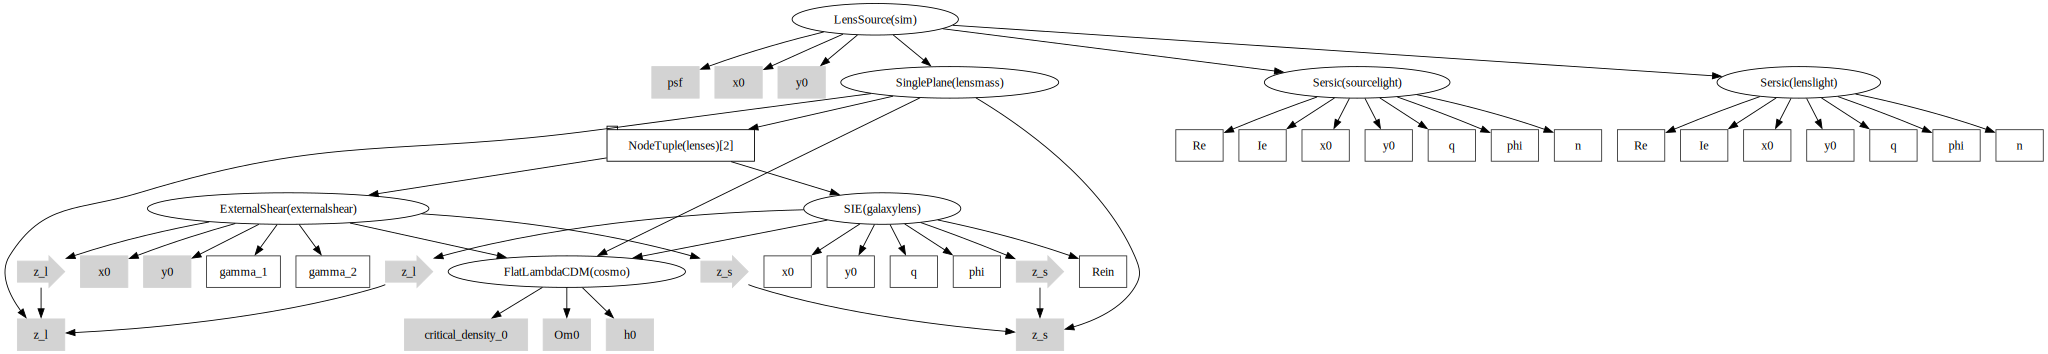

In [147]:
# Lens mass model (SIE + shear)
lens_sie = caustics.SIE(
    name="galaxylens",
    cosmology=cosmology,
    x0=0.05,
    y0=0.0,
    q=0.86,
    phi=-0.20,
    Rein=0.66,
)
lens_sie.to_dynamic()

lens_shear = caustics.ExternalShear(
    name="externalshear",
    cosmology=cosmology,
    x0=0.0,
    y0=0.0,
    gamma_1=0.0,
    gamma_2=-0.05,
)
lens_shear.gamma_1.to_dynamic()
lens_shear.gamma_2.to_dynamic()

lens_mass_model = caustics.SinglePlane(
    name="lensmass",
    cosmology=cosmology,
    lenses=[lens_sie, lens_shear],
    z_l=z_l,
    z_s=z_s,
)

# Lens light model (sersic)
lens_light_model = caustics.Sersic(
    name="lenslight",
    x0=0.05,
    y0=0.0,
    q=0.75,
    phi=1.18,
    n=2.0,
    Re=0.6 / np.sqrt(0.75),
    Ie=16 * pixelscale**2,
)
lens_light_model.to_dynamic()

# Source light model (sersic)
source_light_model = caustics.Sersic(
    name="sourcelight",
    x0=0.1,
    y0=0.0,
    q=0.75,
    phi=1.18,
    n=1.0,
    Re=0.1 / np.sqrt(0.75),
    Ie=16 * pixelscale**2,
)
source_light_model.to_dynamic()

# Gaussian PSF Model
psf_image = caustics.utils.gaussian(
    nx=upsample_factor * 6 + 1,
    ny=upsample_factor * 6 + 1,
    pixelscale=pixelscale / upsample_factor,
    sigma=psf_sigma,
    upsample=2,
)

# Image plane simulator
sim = caustics.LensSource(
    lens=lens_mass_model,
    lens_light=lens_light_model,
    source=source_light_model,
    psf=psf_image,
    pixels_x=numPix,
    pixelscale=pixelscale,
    upsample_factor=upsample_factor,
    quad_level=quad_level,
)
sim.to(dtype=torch.float32)
sim.graphviz()

## Sample some mock data

Here we write out the true values for all the parameters in the model. In total there are 21 parameters, so this is quite a complex model already! We then plot the data so we can see what it is we re trying to fit.

tensor([ 0.0500,  0.0000,  0.8600, -0.2000,  0.6600,  0.0000, -0.0500,  0.1000,
         0.0000,  0.7500,  1.1800,  1.0000,  0.1155,  0.0400,  0.0500,  0.0000,
         0.7500,  1.1800,  2.0000,  0.6928,  0.0400])
1.01107177734375


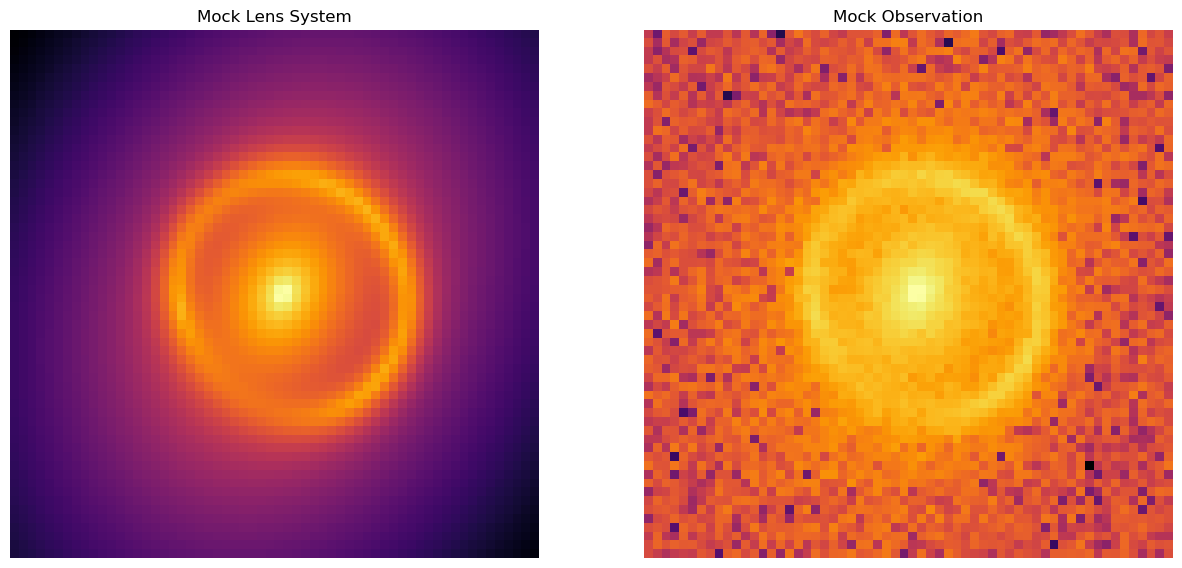

In [148]:
# Generate the mock data
true_params = sim.build_params_array()
print(true_params)

# simulate lens, crop extra evaluation for PSF
true_system = sim(true_params)  # simulate at high resolution

fig, axarr = plt.subplots(1, 2, figsize=(15, 8))
axarr[0].imshow(
    np.log10(true_system.detach().cpu().numpy()), cmap="inferno", origin="lower"
)
axarr[0].axis("off")
axarr[0].set_title("Mock Lens System")
torch.manual_seed(42)
shot_noise = torch.normal(
    mean=torch.zeros_like(true_system),
    std=torch.sqrt(torch.abs(true_system) / exp_time),
)
background = torch.normal(
    mean=torch.zeros_like(true_system), std=torch.tensor(background_rms)
)
variance = (torch.abs(true_system) / exp_time) + background_rms**2
obs_system = true_system + shot_noise + background
print(((obs_system - true_system) ** 2 / variance).sum().item() / 3600)
axarr[1].imshow(
    np.log10(obs_system.abs().detach().cpu().numpy()), cmap="inferno", origin="lower"
)
axarr[1].axis("off")
axarr[1].set_title("Mock Observation")
# plt.colorbar()
plt.show()

In [149]:
def corner_plot(
    chain,
    labels=None,
    figsize=(10, 10),
    true_values=None,
    ellipse_colors="g",
):
    num_params = chain.shape[1]
    cov_matrix = np.cov(chain, rowvar=False)
    mean = np.mean(chain, axis=0)
    fig, axes = plt.subplots(num_params, num_params, figsize=figsize)
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    for i in range(num_params):
        for j in range(num_params):
            ax = axes[i, j]

            if i == j:
                x = np.linspace(
                    mean[i] - 3 * np.sqrt(cov_matrix[i, i]),
                    mean[i] + 3 * np.sqrt(cov_matrix[i, i]),
                    100,
                )
                y = norm.pdf(x, mean[i], np.sqrt(cov_matrix[i, i]))
                ax.plot(x, y, color="g")
                ax.set_xlim(
                    mean[i] - 3 * np.sqrt(cov_matrix[i, i]),
                    mean[i] + 3 * np.sqrt(cov_matrix[i, i]),
                )
                if true_values is not None:
                    ax.axvline(true_values[i], color="red", linestyle="-", lw=1)
            elif j < i:
                ax.scatter(chain[:, j], chain[:, i], color="c", s=0.1, zorder=0)
                cov = cov_matrix[np.ix_([j, i], [j, i])]
                lambda_, v = np.linalg.eig(cov)
                lambda_ = np.sqrt(lambda_)
                angle = np.rad2deg(np.arctan2(v[1, 0], v[0, 0]))
                for k in [1, 2]:
                    ellipse = Ellipse(
                        xy=(mean[j], mean[i]),
                        width=lambda_[0] * k * 2,
                        height=lambda_[1] * k * 2,
                        angle=angle,
                        edgecolor=ellipse_colors,
                        facecolor="none",
                    )
                    ax.add_artist(ellipse)

                # Set axis limits
                margin = 3
                ax.set_xlim(
                    mean[j] - margin * np.sqrt(cov_matrix[j, j]),
                    mean[j] + margin * np.sqrt(cov_matrix[j, j]),
                )
                ax.set_ylim(
                    mean[i] - margin * np.sqrt(cov_matrix[i, i]),
                    mean[i] + margin * np.sqrt(cov_matrix[i, i]),
                )

                if true_values is not None:
                    ax.axvline(true_values[j], color="red", linestyle="-", lw=1)
                    ax.axhline(true_values[i], color="red", linestyle="-", lw=1)

            if j > i:
                ax.axis("off")

            if i < num_params - 1:
                ax.set_xticklabels([])
            else:
                if labels is not None:
                    ax.set_xlabel(labels[j])
            ax.yaxis.set_major_locator(plt.NullLocator())

            if j > 0:
                ax.set_yticklabels([])
            else:
                if labels is not None:
                    ax.set_ylabel(labels[i])
            ax.xaxis.set_major_locator(plt.NullLocator())

    plt.show()

## Fit using emcee

We now model the data using emcee which handles standard Metropolis-Hastings MCMC sampling (plus a few tricks). First we need to construct a log likelihood function. In our case this is just the squared residuals, divided by the variance in each pixel. The rest is specific to the emcee implementation. Note that we must use many walkers due to the algorithm emcee uses, since this is a 21 dimensional problem we need at least 42 chains and we use 64 since that is a nice power of 2.

In [150]:
# Make batched simulator
vsim = torch.vmap(sim)


# Log-likelihood function
def density(x):
    model = vsim(torch.as_tensor(x, dtype=torch.float32))
    log_likelihood_value = -0.5 * torch.sum(
        ((model - obs_system) ** 2) / variance, dim=(1, 2)
    )
    log_likelihood_value = torch.nan_to_num(log_likelihood_value, nan=-np.inf)
    return log_likelihood_value.numpy()


nwalkers = 64
ndim = len(true_params)

sampler = emcee.EnsembleSampler(nwalkers, ndim, density, vectorize=True)

x0 = true_params + 0.01 * torch.randn(nwalkers, ndim, dtype=torch.float32)
print("burn-in")
state = sampler.run_mcmc(x0, 100, skip_initial_state_check=True)  # burn-in
sampler.reset()
print("production")
state = sampler.run_mcmc(state, 1000)  # production

burn-in
production


We have taken 64000 samples in this demo, in general you would want many more (each chain needs to run longer than 1000 steps in order to fully mix). Its always a good idea to plot the chains and check that they don't have any pathological features (i.e. getting frozen at one value). We subtract the mean and divide by the standard deviation of each parameter so that the chains can all be plotted together despite having very different values. Here we can see the non zero autocorrelation length for one of the chains even over 1000 steps. This indicates we should run the chains much longer, but this is just a demo.

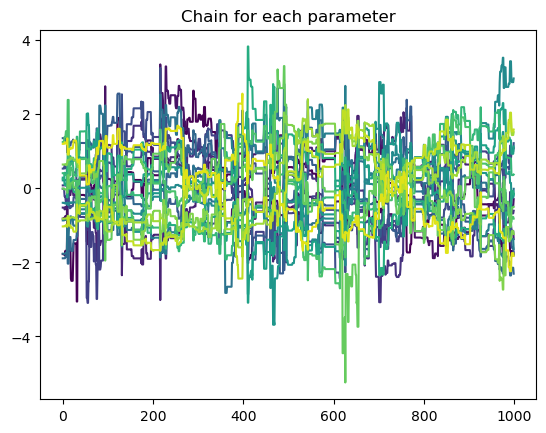

In [151]:
chain_mh = sampler.get_chain()
normed_chains = (chain_mh[:, 0] - np.mean(chain_mh[:, 0], axis=0)) / np.std(
    chain_mh[:, 0], axis=0
)
for i in range(chain_mh.shape[2]):
    plt.plot(normed_chains[:, i], color=colormaps["viridis"](i / chain_mh.shape[2]))
plt.title("Chain for each parameter")
plt.show()

Since the autocorrelation length is >1, we can compute an effective sample size to determine how many equivalent independent points we have drawn. As the warning suggests, in this demo we cannot compute the actual autocorrelation length, the autocorrelation length increases as we draw more samples (you can test this by changing the 1000 above to a larger number). Assuming that the autocorrelation is actually of a similar length to the chain (1000), this means we have drawn approximately 64 independent samples (one for each walker).

In [152]:
print(
    "Autocorrelation time: ",
    np.mean(emcee.autocorr.integrated_time(chain_mh, quiet=True)),
)

The chain is shorter than 50 times the integrated autocorrelation time for 21 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 76.41530441  78.23533296  76.17365807 103.58375568  76.66193838
  76.14747322 100.58615869  81.51240531  82.68342689  80.76675344
  87.89390098  78.58735821  82.52178004  87.24145127  82.35718261
  91.25926854  80.25779296  83.673474   119.71569214 108.66177261
 116.48429903]


Autocorrelation time:  88.16286568831326


We may plot the samples in a corner plot. However, we thin the samples first so that the number of points is not overwhelming to plot. As you can see in the subfigures there is still a bloby structure of the samples, suggesting that the chains were not run long enough to converge and fill the probability volume.

In this figure the green contours show the covariance matrix computed from the samples, the cyan points are the samples themselves, and the red lines are ground truth.

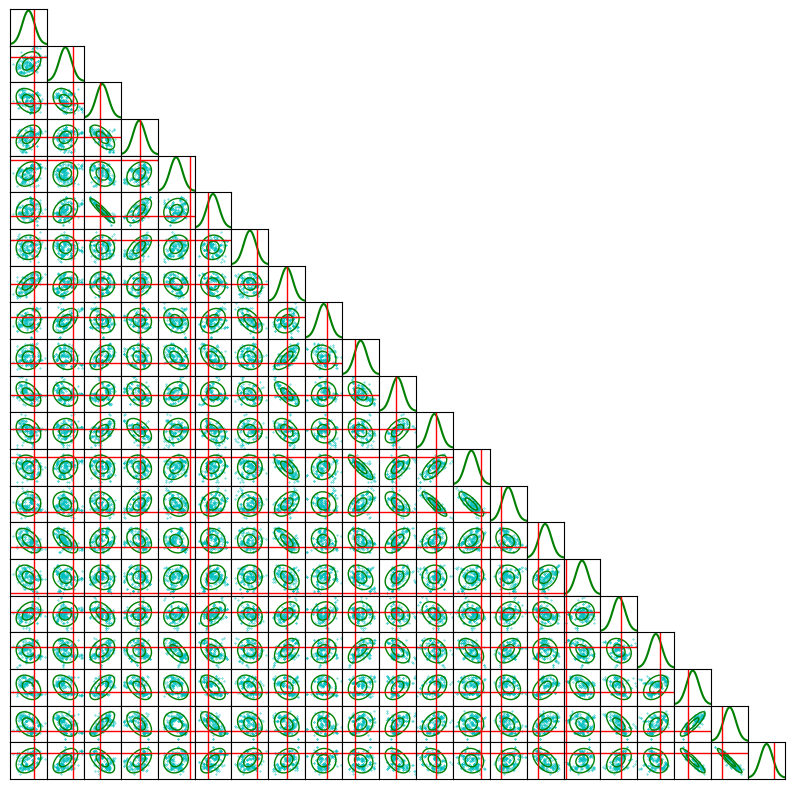

In [153]:
N = chain_mh.shape[0] * chain_mh.shape[1]
fig = corner_plot(
    np.concatenate(chain_mh, axis=0)[:: int(N / 200)],
    true_values=true_params.numpy(),
)
plt.show()

# Fit with MALA sampling

Metropolis Adjusted Langevin Algorithm (MALA) sampling is the half way point between NUTS and MH, it uses gradient information to make an efficient proposal distribution for a MH step. We have written a basic implementation below for demo purposes. Essentially, one uses a random perturbation like in MH, except with a bias towards higher likelihood which comes from the gradient. Detailed balance is maintained using a MH step, so we still sample the correct distribution.

In [155]:
def mala_sampler(
    initial_state,                 # (num_chains, D)
    log_prob,                      # x -> (num_chains,)
    log_prob_grad,                 # x -> (num_chains, D)
    num_samples,
    epsilon,
    mass_matrix,                   # covariance (default) or precision
    mass_is_precision=False,       # set True if you pass Σ^{-1}
    hastings=True,
    progress=True,
    rng=None,
    desc="MALA"
):
    x = np.array(initial_state, copy=True)
    C, D = x.shape

    # Σ, P, L
    if mass_is_precision:
        P = np.array(mass_matrix, copy=False)
        Σ = np.linalg.inv(P)
    else:
        Σ = np.array(mass_matrix, copy=False)
        P = np.linalg.inv(Σ)
    L = np.linalg.cholesky(Σ)

    samples = np.zeros((num_samples, C, D), dtype=x.dtype)

    # Cache current state: BOTH logp and grad
    # (This is the key change: we won’t recompute grad at current every iteration.)
    logp_cur = log_prob(x)                 # (C,)
    grad_cur = log_prob_grad(x)            # (C, D)

    if rng is None:
        rng = np.random.default_rng(seed)

    it = range(num_samples)
    if progress:
        from tqdm import tqdm
        it = tqdm(it, desc=desc,  position=0, leave=True)

    for t in it:
        # proposal using cached grad
        mu_x   = x + 0.5 * (epsilon**2) * (grad_cur @ Σ)
        noise  = rng.standard_normal((C, D)) @ L.T
        x_prop = mu_x + epsilon * noise

        # Evaluate proposed *once*
        logp_prop = log_prob(x_prop)
        grad_prop = log_prob_grad(x_prop)

        if hastings:
            mu_xp = x_prop + 0.5 * (epsilon**2) * (grad_prop @ Σ)

            d1 = x      - mu_xp   # for q(x | x')
            d2 = x_prop - mu_x    # for q(x'| x)

            q1 = np.einsum('bi,ij,bj->b', d1, P, d1)
            q2 = np.einsum('bi,ij,bj->b', d2, P, d2)
            corr = -0.5 * (q1 - q2) / (epsilon**2)

            log_alpha = (logp_prop - logp_cur) + corr
        else:
            log_alpha = (logp_prop - logp_cur)

        accept = np.log(rng.random(C)) < log_alpha

        # Update all three pieces in-place where accepted
        x[accept]        = x_prop[accept]
        logp_cur[accept] = logp_prop[accept]
        grad_cur[accept] = grad_prop[accept]

        samples[t] = x

        if progress:
            it.set_postfix(acc_rate=f"{accept.mean():0.2f}")

    return samples

Here we run the MALA sampler after a small burn-in. We cheat a little bit and use the previous sampler to construct a mass matrix, this makes MALA more efficient but you could just as easily set the mass matrix to identity for the burn-in then use the burn-in samples to get a mass matrix, it only requires more fiddling with parameters (epsilon).

In [156]:
def density_grad(x):
    x = torch.as_tensor(x, dtype=torch.float32)
    x.requires_grad = True
    model = vsim(x)
    log_likelihood_value = -0.5 * torch.sum(
        ((model - obs_system) ** 2) / variance, dim=(1, 2)
    )
    log_likelihood_value = torch.nan_to_num(log_likelihood_value, nan=-np.inf)
    log_likelihood_value.sum().backward()
    return x.grad.numpy()


nwalkers = 32
x0 = true_params + 0.01 * torch.randn(nwalkers, ndim, dtype=torch.float32)
cov = np.cov(chain_mh.reshape(-1, ndim), rowvar=False)
#cov = np.linalg.inv(np.cov(chain_mh.reshape(-1, ndim), rowvar=False))

chain_burnin_mala = mala_sampler(
    initial_state=x0,
    log_prob=density,
    log_prob_grad=density_grad,
    num_samples=100,
    epsilon=3e-1,
    mass_matrix=cov,
    desc = "Warmup"
)  # burn-in

chain_mala = mala_sampler(
    initial_state=chain_burnin_mala[-1],
    log_prob=density,
    log_prob_grad=density_grad,
    num_samples=1000,
    epsilon=7e-1,
    mass_matrix=cov,
    desc = "Production"
)  # production

Production: 100%|██████████████████████| 1000/1000 [00:16<00:00, 59.69it/s, acc_rate=0.81]


Plotting the chains we see that they mix much better than the MH sampler, but still have some autocorrelation, as would be expected.

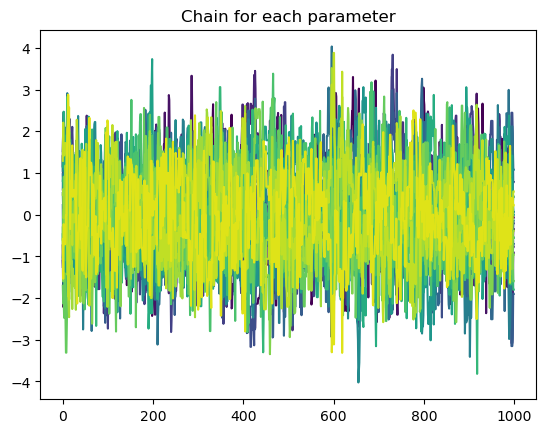

In [157]:
walker = 1
normed_chains = (chain_mala[:, walker] - np.mean(chain_mala[:, walker], axis=0)) / np.std(
    chain_mala[:, walker], axis=0
)
for i in range(chain_mala.shape[2]):
    plt.plot(normed_chains[:, i], color=colormaps["viridis"](i / chain_mala.shape[2]))
plt.title("Chain for each parameter")
plt.show()

The autocorrelation length is better than MH as expected. Again the effective sample size can't be trusted and is probably a bit larger than the 64 value from before.

In [158]:
print(
    "Autocorrelation time: ",
    np.mean(emcee.autocorr.integrated_time(chain_mala, quiet=True)),
)

The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [15.32621034 11.15110978 19.39331489 23.92955049 10.91173878 19.41794283
 22.21479298 12.53471437 15.34468251 20.85027494 21.59958514 34.30659618
 33.92737221 35.19052361  8.13412511  7.81407311 10.18749162 13.13616401
 25.36707205 24.86360195 25.88944834]


Autocorrelation time:  19.594780249296605


The corner plot is much better than the MH example, we can see how the volume is filled out more with fewer gaps, suggesting we have sampled a good chunk of the space.

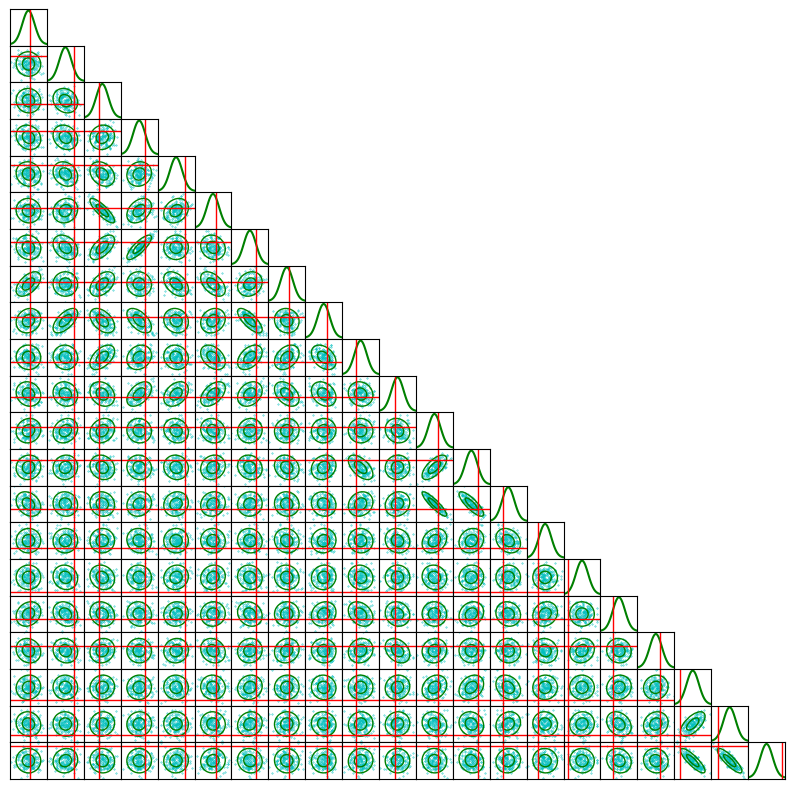

In [159]:
N = chain_mala.shape[0] * chain_mala.shape[1]
fig = corner_plot(
    np.concatenate(chain_mala, axis=0)[:: int(N / 200)],
    true_values=true_params.numpy(),
)
plt.show()

## Fit using NUTS

We now model the data using NUTS. A prior is required, so we just set some extremely wide values so that we will explore just the likelihood; in general one would want to pick more informative priors. The rest is specific to the Pyro NUTS implementation!

Note, we use 25 warmup steps for Pyro, this is so it can automatically determine an appropriate "mass matrix" which helps the sampler explore much more efficiently! NUTS can also determine its own step size and build a full mass matrix. For a real analysis you would likely want to take many warm up steps so it can figure these things out accurately, afterwards the sampling will be incredibly efficient. For the sake of time in this demo, we preset a bunch of parameters and restrict what it can do, we will still get quite excellent samples.

In [21]:
def step(model, prior):
    x = pyro.sample("x", prior)
    # Log-likelihood function
    res = model(x)
    log_likelihood_value = -0.5 * torch.sum(((res - obs_system) ** 2) / variance)
    # Observe the log-likelihood
    pyro.factor("obs", log_likelihood_value)


prior = dist.Normal(
    true_params,
    torch.ones_like(true_params) * 1e2 + torch.abs(true_params) * 1e2,
)
nuts_kwargs = {
    "jit_compile": True,
    "ignore_jit_warnings": True,
    "step_size": 2e-2,
    "full_mass": False,
    "adapt_step_size": False,
    "adapt_mass_matrix": True,
    "target_accept_prob": 0.8,
    "max_tree_depth": 8,
}

nuts_kernel = pyro_NUTS(step, **nuts_kwargs)
init_params = {"x": true_params.clone()}

# Run MCMC with the NUTS sampler and the initial guess
mcmc_kwargs = {
    "num_samples": 100,
    "warmup_steps": 25,
    "initial_params": init_params,
    "disable_progbar": False,
}

mcmc = pyro_MCMC(nuts_kernel, **mcmc_kwargs)

mcmc.run(sim, prior)

Sample: 100%|████████████| 125/125 [00:53,  2.33it/s, step size=2.00e-02, acc. prob=0.897]


We have only taken 100 samples in this demo, in general you would want many more. Again we plot the chains and check that they look uncorrelated, everything seems fine here! There is much less structure than before, it looks like we are sampling random noise which is ideal.

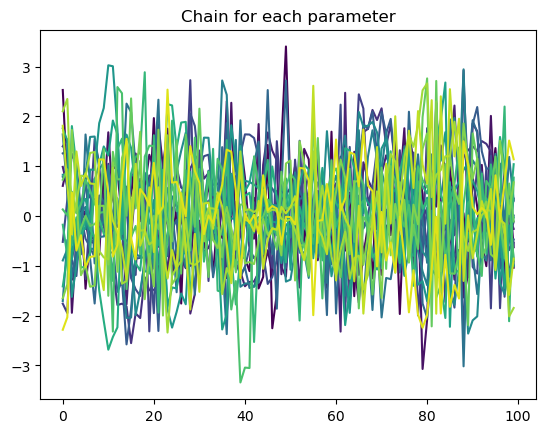

Autocorrelation time:  2.168325854845718


In [22]:
chain_nuts = mcmc.get_samples()["x"]
chain_nuts = chain_nuts.numpy()

normed_chains = (chain_nuts - np.mean(chain_nuts, axis=0)) / np.std(chain_nuts, axis=0)
for i in range(chain_nuts.shape[1]):
    plt.plot(normed_chains[:, i], color=colormaps["viridis"](i / chain_nuts.shape[1]))
plt.title("Chain for each parameter")
plt.show()

print(
    "Autocorrelation time: ",
    np.mean(
        emcee.autocorr.integrated_time(
            chain_nuts, has_walkers=False, tol=10, quiet=True
        )
    ),
)

As is common for NUTS sampling, the average autocorrelation time for the parameters is around 1, meaning that essentially every sample is independent. 

Finally, we show the corner plot where the samples are very well distributed as we would expect for uncorrelated samples.

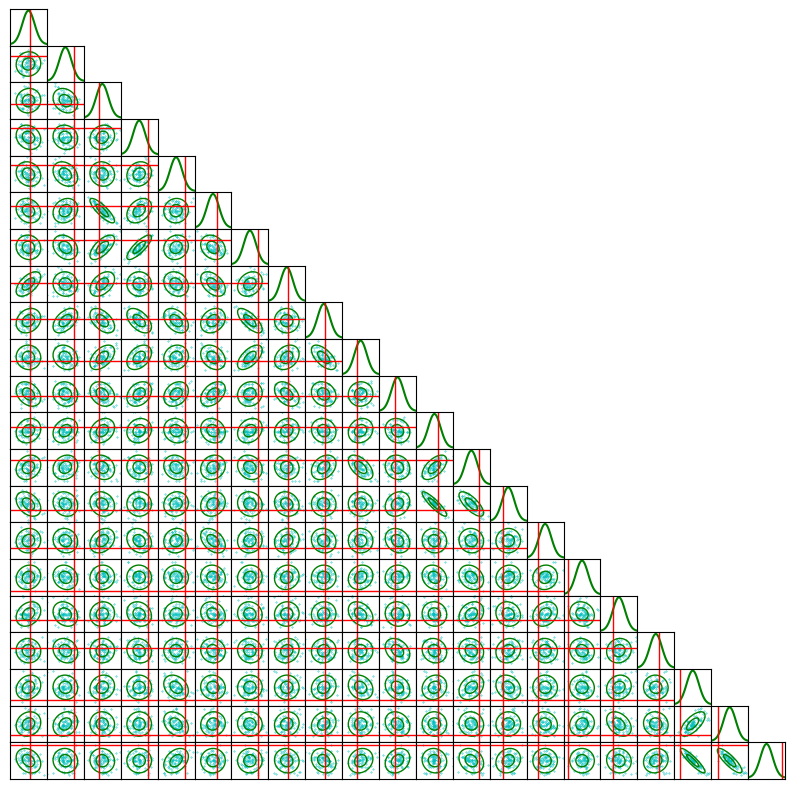

In [23]:
fig = corner_plot(chain_nuts, true_values=true_params.numpy())
plt.show()

The Pyro NUTS implementation is very convenient in that it handles the tuning of all parameters automatically in the warmup phase. In practice however, the small but efficient steps of MALA often make it very efficient, plus the rapid progress makes it easier to tweak and tune the sampler to your problem. Emcee will struggle with high dimensional problems, it was already having a hard time at 21 dimensions and gravitational lensing analysis can go much beyond 21 parameters, but it doesn't require gradient computations which may be impractical for some forward models. In the end, your specific problem will likely determine which algorithm to use.